# **SECTION 0: Imports**

In [ ]:
import sys

import random

import numpy as np

import pandas as pd 

from typing import List
from tqdm import tqdm
import collections

import tensorflow as tf
import keras
from keras.utils import np_utils

import pickle
import copy

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

# **SECTION 1: Data Preprocessing**

### Data Acquisition

Associated Labels:
*   0: T-shirt/top1
*   1: Trouser 
*   2: Pullover
*   3: Dress
*   4: Coat 
*   5: Sandal
*   6: Shirt
*   7: Sneaker
*   8: Bag
*   9: Ankle boot
 

In [ ]:
# Import dataset
fashion_data = tf.keras.datasets.fashion_mnist
(X_train_fashion_original, y_train_fashion_original), (X_test_fashion_original, y_test_fashion_original) = fashion_data.load_data()
assert X_train_fashion_original.shape == (60000, 28, 28)
assert X_test_fashion_original.shape == (10000, 28, 28)
assert y_train_fashion_original.shape == (60000,)
assert y_test_fashion_original.shape == (10000,)

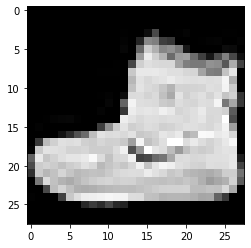

Label: 9


In [ ]:
# Verify train dataset correctness
plt.imshow(X_train_fashion_original[0], cmap='gray')
plt.show()
print("Label:", y_train_fashion_original[0])

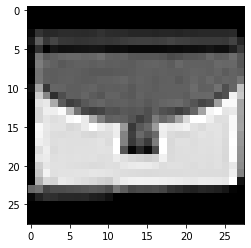

Label: 8


In [ ]:
# Verify test dataset correctness
plt.imshow(X_test_fashion_original[78], cmap='gray')
plt.show()
print("Label:", y_test_fashion_original[78])

In [ ]:
# Data exploration
print("X_train_fashion dataset shape: ", X_train_fashion_original.shape)
print("y_train_fashion dataset shape: ", y_train_fashion_original.shape)
print("X_test_fashion dataset shape: ", X_test_fashion_original.shape)
print("y_test_fashion dataset shape: ", y_test_fashion_original.shape)
print("Train class distribution: ", collections.Counter(y_train_fashion_original))
print("Test class distribution: ", collections.Counter(y_test_fashion_original))
print("Check train dataset for any NaN values: ", any(np.isnan(X_train_fashion_original.shape)))
print("Check test dataset for any NaN values: ", any(np.isnan(X_test_fashion_original.shape)))

X_train_fashion dataset shape:  (60000, 28, 28)
y_train_fashion dataset shape:  (60000,)
X_test_fashion dataset shape:  (10000, 28, 28)
y_test_fashion dataset shape:  (10000,)
Train class distribution:  Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Test class distribution:  Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})
Check train dataset for any NaN values:  False
Check test dataset for any NaN values:  False


### Fashion-MNIST Un-Normalized

(60000, 784)
(60000,)
(10000, 784)
(10000,)


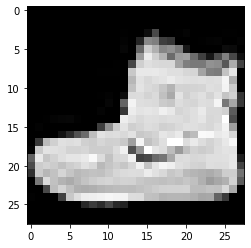

Label: 9


In [ ]:
X_train_fashion = X_train_fashion_original.reshape(X_train_fashion_original.shape[0], -1); # (60000, 784)
y_train_fashion = y_train_fashion_original # (60000, 1)
X_test_fashion = X_test_fashion_original.reshape(X_test_fashion_original.shape[0], -1) # (10000, 784)
y_test_fashion = y_test_fashion_original # (10000, 1)
print(X_train_fashion.shape)
print(y_train_fashion.shape)
print(X_test_fashion.shape)
print(y_test_fashion.shape)

plt.imshow(X_train_fashion[0].reshape(28,28), cmap='gray')
plt.show()
print("Label:", y_train_fashion[0])

### Fashion-MNIST Normalized

In [ ]:
# Normalize data
scaler = MinMaxScaler()
X_train_fashion_normalized = scaler.fit_transform(X_train_fashion)
X_test_fashion_normalized = scaler.fit_transform(X_test_fashion)

X_train_fashion_normalized_v2 = X_train_fashion / 255.0
X_test_fashion_v2 = X_test_fashion / 255.0

### Data Normalized with StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_fashion_std = scaler.fit_transform(X_train_fashion)
X_test_fashion_std = scaler.fit_transform(X_test_fashion)

# **SECTION 2: Machine Learning Algorithm Implementations**

## **MLP Implementation 1**

### Layer Classes

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size, l2_regularization_weight=0):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.l2_regularization_weight = l2_regularization_weight
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient

        if self.l2_regularization_weight > 0:
          dw += self.l2_regularization_weight * self.w

        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

### MLP Class

In [ ]:
# evaluate the model accuracy
def evaluate_acc(y, yh):
    accuracy = sum(yh == y) / y.shape[0]
    return accuracy

In [ ]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def fit(self, optimizer, data_x, data_y, steps, batch_size, showplot=False):
        print("")
        losses = []
        accuracies = []
        for i in tqdm(range(1, steps + 1)):
            # Generate batch
            indices = np.random.choice(60000, batch_size)
            x, y = data_x[indices], data_y[indices]
            labels = np.eye(10)[np.array(y)]
            # Forward pass
            predictions = self.forward(x)
            # Calculate loss
            if showplot:
                loss = -(labels * np.log(predictions+1e-300)).sum(axis=-1).mean()
                losses.append(loss)
                acc = evaluate_acc(y, np.argmax(predictions, axis=1))
                accuracies.append(acc)
            # Backward pass
            self.backward(labels)
            # Optimize
            optimizer.step()
        if showplot:
            plt.figure(figsize=(15,5))
            plt.subplot(121), plt.plot(losses)
            plt.title("Plot of CE as function of Epochs"), plt.xlabel("Epoch"), plt.ylabel("Cross entropy loss")
            plt.subplot(122), plt.plot(accuracies)
            plt.title("Plot of Accuracy as function of Epochs"), plt.xlabel("Epoch"), plt.ylabel("Train accuracy")

    def predict(self, data_x):
        predictions = self.forward(data_x)
        return np.argmax(predictions, axis=1)

### Optimizer Class

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

## **MLP Implementation 2**

In [ ]:
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l2=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.matmul(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        
        self.dinputs = np.dot(dvalues, self.weights.T)

    def get_parameters(self):
        return self.weights, self.biases

    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases

class Activation_Leaky_ReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.where(inputs > 0, inputs, inputs * self.alpha)  

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs = dvalues*(np.where(self.inputs >= 0, 1, self.alpha))

    def predictions(self, outputs):
        return outputs

class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

    def predictions(self, outputs):
        return outputs


class Activation_Tanh:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.tanh(inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues*(1.-((self.output)**2))

    def predictions(self, outputs):
        return outputs

class Activation_Softmax:
    def forward(self, inputs, training):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)

class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

class Loss:
    def regularization_loss(self):
        regularization_loss = 0
        for layer in self.trainable_layers:
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7) # clip data to prevent division by 0
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples # normalizing gradient output value

class Activation_Softmax_Loss_CategoricalCrossentropy():
    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples # normalize the gradient

class Accuracy:
    def calculate(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        return accuracy

    def calculate_accumulated(self):
        accuracy = self.accumulated_sum / self.accumulated_count
        return accuracy
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        self.binary = binary

    def init(self, y):
        pass

    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y

class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs

# Model class
class Model:
    def __init__(self):
        self.layers = []
        self.softmax_classifier_output = None
        self.validation_accuracies = []
        self.training_accuracies = []
        self.loss_accuracies = []

    # Add objects to the model
    def add(self, layer):
        self.layers.append(layer)

    # Set loss, optimizer and accuracy
    def set(self, *, loss=None, optimizer=None, accuracy=None):
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy

    # Finalize the model
    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []

        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)

        if isinstance(self.layers[-1], Activation_Softmax) and isinstance(self.loss, Loss_CategoricalCrossentropy):
            self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossentropy()

    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None):
        self.accuracy.init(y)
        train_steps = 1
        if batch_size is not None:
            train_steps = len(X) // batch_size
            if train_steps * batch_size < len(X):
                train_steps += 1

        for epoch in range(1, epochs+1):
            print(f'epoch: {epoch}')

            self.loss.new_pass()
            self.accuracy.new_pass()

            for step in range(train_steps):
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]

                output = self.forward(batch_X, training=True)

                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)
                self.backward(output, batch_y)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()
                
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, ' + f'acc: {accuracy:.3f}, ' +  f'loss: {loss:.3f} (' + f'data_loss: {data_loss:.3f}, ' + f'reg_loss: {regularization_loss:.3f}), ' + f'lr: {self.optimizer.current_learning_rate}')

            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            self.training_accuracies.append(accuracy)
            print(f'training, ' + f'acc: {epoch_accuracy:.3f}, ' + f'loss: {epoch_loss:.3f} (' + f'data_loss: {epoch_data_loss:.3f}, ' + f'reg_loss: {epoch_regularization_loss:.3f}), ' + f'lr: {self.optimizer.current_learning_rate}')

            if validation_data is not None:
                self.evaluate(*validation_data, batch_size=batch_size)

    def evaluate(self, X_val, y_val, *, batch_size=None):
        validation_steps = 1

        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1
        self.loss.new_pass()
        self.accuracy.new_pass()

        for step in range(validation_steps):
            if batch_size is None:
                batch_X = X_val
                batch_y = y_val
            else:
                batch_X = X_val[step*batch_size:(step+1)*batch_size]
                batch_y = y_val[step*batch_size:(step+1)*batch_size]
            output = self.forward(batch_X, training=False)
            self.loss.calculate(output, batch_y)
            predictions = self.output_layer_activation.predictions(output)
            self.accuracy.calculate(predictions, batch_y)
        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()
        self.validation_accuracies.append(validation_accuracy)
        print(f'validation, ' + f'acc: {validation_accuracy:.3f}, ' + f'loss: {validation_loss:.3f}')
        
    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        output = []
        for step in range(prediction_steps):
            if batch_size is None:
                batch_X = X
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)
        return np.vstack(output)
    def forward(self, X, training):
        self.input_layer.forward(X, training)
        for layer in self.layers:
            layer.forward(layer.prev.output, training)
        return layer.output

    def backward(self, output, y):
        if self.softmax_classifier_output is not None:
            self.softmax_classifier_output.backward(output, y)
            self.layers[-1].dinputs = self.softmax_classifier_output.dinputs
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)
            return

        self.loss.backward(output, y)
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)

    def get_parameters(self):
        parameters = []
        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())
        return parameters

    def set_parameters(self, parameters):
        for parameter_set, layer in zip(parameters, self.trainable_layers): layer.set_parameters(*parameter_set)

# Code learned from textbook: Harrison Kinsley & Daniel Kukieła Neural Networks from Scratch (NNFS) https://nnfs.io

# **SECTION 3: Experiments**

## **Part 0 - Choosing MLP hyperparameters.**



### CNN 

In [ ]:
# Normalizing and reshaping the data
# First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5]. 
# Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
X_train_fashion_normalized_cnn = (X_train_fashion_original / 255) - 0.5
X_test_fashion_normalized_cnn = (X_test_fashion_original / 255) - 0.5

print(X_train_fashion_normalized_cnn.shape) # (60000, 28, 28)
print(X_test_fashion_normalized_cnn.shape)  # (10000, 28, 28)

# Reshape the images.
X_train_fashion_normalized_cnn = np.expand_dims(X_train_fashion_normalized_cnn, axis=3)
X_test_fashion_normalized_cnn = np.expand_dims(X_test_fashion_normalized_cnn, axis=3)

print(X_train_fashion_normalized_cnn.shape) # (60000, 28, 28, 1)
print(X_test_fashion_normalized_cnn.shape)  # (10000, 28, 28, 1)

y_train_fashion_cnn = keras.utils.np_utils.to_categorical(y_train_fashion_original)
y_test_fashion_cnn = keras.utils.np_utils.to_categorical(y_test_fashion_original)
print(y_train_fashion_cnn.shape) # (60000, 10)
print(y_test_fashion_cnn.shape)  # (10000, 10)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
optimizer = keras.optimizers.SGD(lr=0.001)
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
# model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers
cnn_model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
cnn_model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model.add(Dense(128, activation='relu')) # fully connected layer
cnn_model.add(Dense(num_classes, activation='softmax')) # output layer

# Compile the model
cnn_model.compile(
  optimizer=optimizer,                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

# Fitting the model
history = cnn_model.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=5,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
)

Epoch 1/5
938/938 [==============================] - 181s 192ms/step - loss: 1.3201 - accuracy: 0.6064 - val_loss: 0.7254 - val_accuracy: 0.7306
Epoch 2/5
938/938 [==============================] - 183s 195ms/step - loss: 0.6524 - accuracy: 0.7600 - val_loss: 0.6152 - val_accuracy: 0.7701
Epoch 3/5
938/938 [==============================] - 180s 192ms/step - loss: 0.5833 - accuracy: 0.7860 - val_loss: 0.5700 - val_accuracy: 0.7923
Epoch 4/5
938/938 [==============================] - 183s 195ms/step - loss: 0.5458 - accuracy: 0.8023 - val_loss: 0.5419 - val_accuracy: 0.8030
Epoch 5/5
938/938 [==============================] - 183s 195ms/step - loss: 0.5219 - accuracy: 0.8090 - val_loss: 0.5288 - val_accuracy: 0.8066


### MLP Implementation 1

### Small Pertubation Analysis

In [ ]:
layer = mlp.layers[4]
upper_layer = mlp.layers[5]

w = layer.w
b = layer.b
print(w.shape) # (10, 128)
print(b.shape) # (10,)

dw, db = layer.gradient
dw_num = dw.mean(axis=0)
db_num = db.mean(axis=0)
print(dw_num.shape) # (10, 128)
print(db_num.shape) # (10,)

w0 = w
epsilon = 1e-3 #np.random.randn(1)[0] * 1e-5
w1 = w0 + epsilon
w2 = w0 - epsilon
# print(w0, w1, w2)

x = layer.cur_input
a1 = (w1[None, :, :] @ x[:, :, None]).squeeze() + b
a2 = (w2[None, :, :] @ x[:, :, None]).squeeze() + b
print(x.shape)
print(a1.shape)

yh1 = upper_layer.forward(a1)
yh2 = upper_layer.forward(a2)
print(yh1.shape)

y = np.eye(10)[np.array(y_test)]
print(y.shape)

L1 = -(y * np.log(yh1+1e-300)).sum(axis=-1).mean()
L2 = -(y * np.log(yh2+1e-300)).sum(axis=-1).mean()
print(L1, L2)

dw_num = (L1 - L2)/(2*epsilon)
print(dw_num)

In [ ]:
# Number of features & classes
n_features = 784
n_classes = 10

# Number of neurons
K1 = 128    # Layer 1
K2 = 128    # Layer 2

# Hyper-parameters
epochs = 500
batch_size = 256

lr_choices = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
accuracies = []

for lr in lr_choices:
    mlp = MLP(
        # First Layer
        LinearLayer(n_features, K1),
        ReLULayer(),
        # Second Layer
        LinearLayer(K1, K2),
        ReLULayer(),
        # Output Layer
        LinearLayer(K2, n_classes),
        SoftmaxOutputLayer()
    )
    opt = GradientDescentOptimizer(mlp, lr)

    mlp.fit(opt, X_train_fashion_normalized, y_train_fashion, epochs, batch_size, showplot=False)

    # Performance on Train dataset
    yh_train = mlp.predict(X_train_fashion_normalized)
    acc_train = evaluate_acc(y_train_fashion, yh_train)

    # Performance on Test dataset
    yh_test = mlp.predict(X_test_fashion_normalized)
    acc_test = evaluate_acc(y_test_fashion, yh_test)

    accuracies.append((acc_train, acc_test))

print(lr_choices)
print(accuracies)

100%|██████████| 500/500 [02:10<00:00,  3.82it/s]


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


100%|██████████| 500/500 [02:02<00:00,  4.08it/s]


100%|██████████| 500/500 [02:13<00:00,  3.74it/s]


100%|██████████| 500/500 [02:12<00:00,  3.77it/s]


100%|██████████| 500/500 [01:52<00:00,  4.46it/s]


[0.001, 0.01, 0.05, 0.1, 0.5, 1]
[(0.69145, 0.6843), (0.6509833333333334, 0.6463), (0.41178333333333333, 0.4072), (0.12461666666666667, 0.1254), (0.1, 0.1), (0.09998333333333333, 0.1)]


### Learning Rate: MLP Implementation 2

In [ ]:
learning_rate_choices = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1]
# Instantiate the model
model_test_params = Model()
# Add layers
model_test_params.add(Layer_Dense(X_train_fashion_normalized.shape[1], 128))
model_test_params.add(Activation_ReLU())
model_test_params.add(Layer_Dense(128, 128))
model_test_params.add(Activation_ReLU())
model_test_params.add(Layer_Dense(128, 10))
model_test_params.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model_test_params.set(
loss=Loss_CategoricalCrossentropy(),
optimizer=Optimizer_SGD(learning_rate=1), # Plug the different values to observe accuracy results
accuracy=Accuracy_Categorical()
)

# Finalize the model
model_test_params.finalize()
# Train the model
model_test_params.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=128, print_every=100)
model_test_params.evaluate(X_test_fashion_normalized, y_test_fashion)

epoch: 1
step: 0, acc: 0.109, loss: 2.303 (data_loss: 2.303, reg_loss: 0.000), lr: 1
step: 100, acc: 0.172, loss: 1.984 (data_loss: 1.984, reg_loss: 0.000), lr: 1
step: 200, acc: 0.375, loss: 1.452 (data_loss: 1.452, reg_loss: 0.000), lr: 1
step: 300, acc: 0.461, loss: 1.185 (data_loss: 1.185, reg_loss: 0.000), lr: 1
step: 400, acc: 0.406, loss: 1.619 (data_loss: 1.619, reg_loss: 0.000), lr: 1
step: 468, acc: 0.260, loss: 1.832 (data_loss: 1.832, reg_loss: 0.000), lr: 1
training, acc: 0.300, loss: 1.735 (data_loss: 1.735, reg_loss: 0.000), lr: 1
validation, acc: 0.295, loss: 1.647
epoch: 2
step: 0, acc: 0.227, loss: 1.616 (data_loss: 1.616, reg_loss: 0.000), lr: 1
step: 100, acc: 0.414, loss: 1.289 (data_loss: 1.289, reg_loss: 0.000), lr: 1
step: 200, acc: 0.414, loss: 1.986 (data_loss: 1.986, reg_loss: 0.000), lr: 1
step: 300, acc: 0.414, loss: 1.291 (data_loss: 1.291, reg_loss: 0.000), lr: 1
step: 400, acc: 0.422, loss: 1.377 (data_loss: 1.377, reg_loss: 0.000), lr: 1
step: 468, acc:

## **Main Implementation 1: Part 1 - MLP variants and softmax classification.**

### MLP with no hidden layer 

100%|██████████| 5000/5000 [01:32<00:00, 53.90it/s]


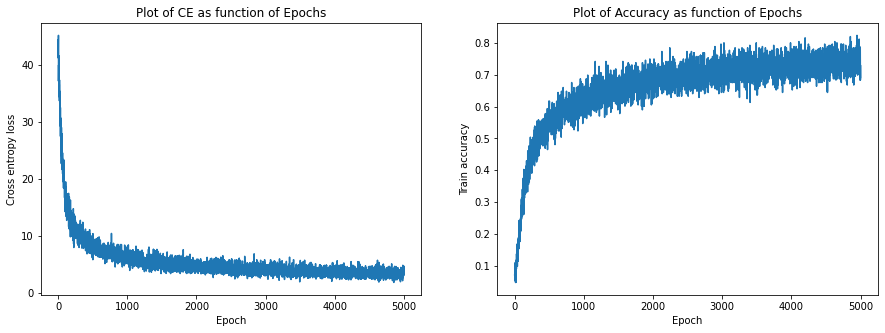

In [ ]:
# Hyper-parameters
epochs = 5000
batch_size = 256
lr = 1e-2

mlp0 = MLP(
    # Output Layer
    LinearLayer(n_features, n_classes),
    SoftmaxOutputLayer()
)
opt0 = GradientDescentOptimizer(mlp0, lr)

mlp0.fit(opt0, X_train_fashion_std, y_train_fashion, epochs, batch_size, showplot=True)

In [ ]:
# Performance on Train dataset
yh_train = mlp0.predict(X_train_fashion_std)
print("Train accuracy:", evaluate_acc(y_train_fashion, yh_train))

# Performance on Test dataset
yh_test = mlp0.predict(X_test_fashion_std)
print("Train accuracy:", evaluate_acc(y_test_fashion, yh_test))

Train accuracy: 0.7420333333333333
Train accuracy: 0.7364


### MLP with 1 hidden layer and ReLU activations

100%|██████████| 2500/2500 [08:16<00:00,  5.04it/s]


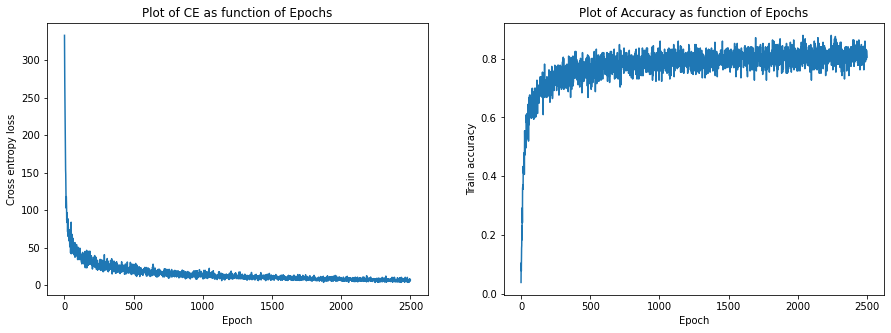

In [ ]:
# Number of neurons
K1 = 128    # Layer 1

# Hyper-parameters
epochs = 2500
batch_size = 256
lr = 1e-2

mlp1 = MLP(
    # First Layer
    LinearLayer(n_features, K1),
    ReLULayer(),
    # Output Layer
    LinearLayer(K1, n_classes),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, lr)

mlp1.fit(opt1, X_train_fashion_std, y_train_fashion, epochs, batch_size, showplot=True)

In [ ]:
# Performance on Train dataset
yh_train = mlp1.predict(X_train_fashion_std)
print("Train accuracy:", evaluate_acc(y_train_fashion, yh_train))

# Performance on Test dataset
yh_test = mlp1.predict(X_test_fashion_std)
print("Train accuracy:", evaluate_acc(y_test_fashion, yh_test))

Train accuracy: 0.8099333333333333
Train accuracy: 0.7911


### MLP with 2 hidden layers and ReLU activations

100%|██████████| 1250/1250 [04:49<00:00,  4.32it/s]


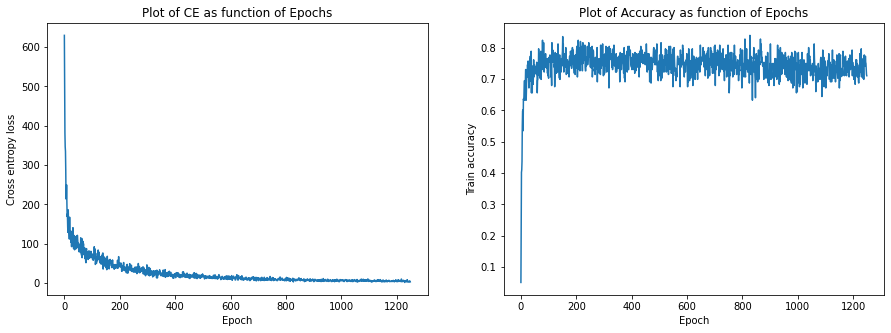

In [ ]:
# Number of neurons
K1 = 128    # Layer 1
K2 = 128    # Layer 2

# Hyper-parameters
epochs = 1250
batch_size = 256
lr = 1e-2

mlp2 = MLP(
    # First Layer
    LinearLayer(n_features, K1),
    ReLULayer(),
    # Second Layer
    LinearLayer(K1, K2),
    ReLULayer(),
    # Output Layer
    LinearLayer(K2, n_classes),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, lr)

mlp2.fit(opt2, X_train_fashion_std, y_train_fashion, epochs, batch_size, showplot=True)

In [ ]:
# Performance on Train dataset
yh_train = mlp2.predict(X_train_fashion_std)
print("Train accuracy:", evaluate_acc(y_train_fashion, yh_train))

# Performance on Test dataset
yh_test = mlp2.predict(X_test_fashion_std)
print("Train accuracy:", evaluate_acc(y_test_fashion, yh_test))

Train accuracy: 0.74295
Train accuracy: 0.7249


## **Implementation 2: Part 1 - MLP variants and softmax classification.**

### MLP with no hidden layer 

epoch: 1
step: 0, acc: 0.125, loss: 2.309 (data_loss: 2.309, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.805, loss: 0.676 (data_loss: 0.676, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.773, loss: 0.582 (data_loss: 0.582, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.828, loss: 0.580 (data_loss: 0.580, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.758, loss: 0.652 (data_loss: 0.652, reg_loss: 0.000), lr: 0.1
step: 468, acc: 0.844, loss: 0.488 (data_loss: 0.488, reg_loss: 0.000), lr: 0.1
training, acc: 0.773, loss: 0.688 (data_loss: 0.688, reg_loss: 0.000), lr: 0.1
validation, acc: 0.811, loss: 0.565
epoch: 2
step: 0, acc: 0.867, loss: 0.429 (data_loss: 0.429, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.859, loss: 0.463 (data_loss: 0.463, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.820, loss: 0.466 (data_loss: 0.466, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.859, loss: 0.508 (data_loss: 0.508, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.797, loss: 0.595 (data_loss: 0.595, reg_loss: 0.000),

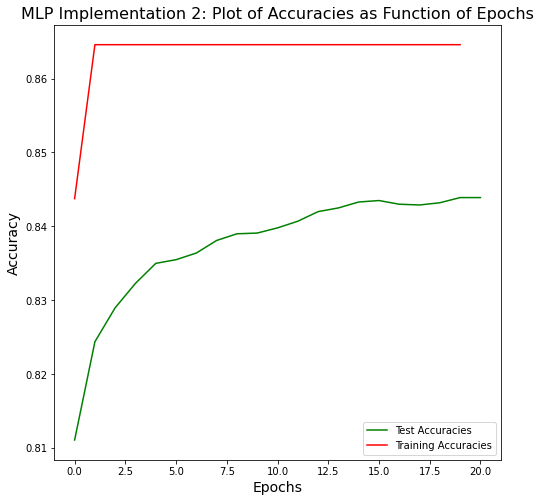

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion_normalized.shape[1], 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_SGD(learning_rate=0.1),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=128, print_every=100)
model.evaluate(X_test_fashion_normalized, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()


### MLP with 1 hidden layer and ReLU activations

epoch: 1
step: 0, acc: 0.109, loss: 2.302 (data_loss: 2.302, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.656, loss: 0.862 (data_loss: 0.862, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.703, loss: 0.694 (data_loss: 0.694, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.789, loss: 0.617 (data_loss: 0.617, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.719, loss: 0.678 (data_loss: 0.678, reg_loss: 0.000), lr: 0.1
step: 468, acc: 0.833, loss: 0.497 (data_loss: 0.497, reg_loss: 0.000), lr: 0.1
training, acc: 0.693, loss: 0.864 (data_loss: 0.864, reg_loss: 0.000), lr: 0.1
validation, acc: 0.799, loss: 0.574
epoch: 2
step: 0, acc: 0.852, loss: 0.452 (data_loss: 0.452, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.797, loss: 0.536 (data_loss: 0.536, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.781, loss: 0.464 (data_loss: 0.464, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.844, loss: 0.479 (data_loss: 0.479, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.758, loss: 0.596 (data_loss: 0.596, reg_loss: 0.000),

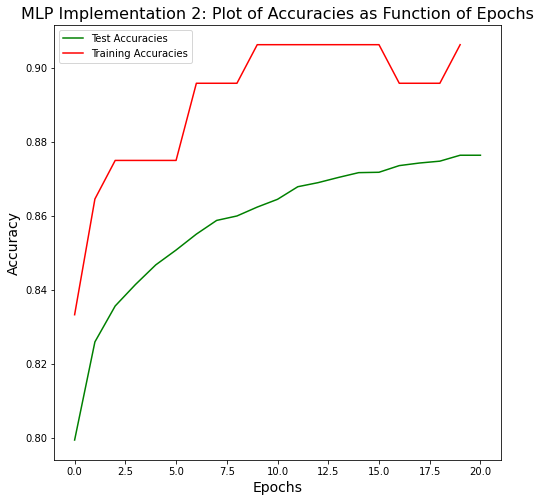

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion_normalized.shape[1], 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
loss=Loss_CategoricalCrossentropy(),
optimizer=Optimizer_SGD(learning_rate=0.1),
accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=128, print_every=100)
model.evaluate(X_test_fashion_normalized, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()

### MLP with 2 hidden layers and ReLU activations

epoch: 1
step: 0, acc: 0.125, loss: 2.303 (data_loss: 2.303, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.180, loss: 2.283 (data_loss: 2.283, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.391, loss: 1.334 (data_loss: 1.334, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.555, loss: 1.208 (data_loss: 1.208, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.641, loss: 0.908 (data_loss: 0.908, reg_loss: 0.000), lr: 0.1
step: 468, acc: 0.688, loss: 0.839 (data_loss: 0.839, reg_loss: 0.000), lr: 0.1
training, acc: 0.429, loss: 1.494 (data_loss: 1.494, reg_loss: 0.000), lr: 0.1
validation, acc: 0.689, loss: 0.827
epoch: 2
step: 0, acc: 0.734, loss: 0.716 (data_loss: 0.716, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.758, loss: 0.664 (data_loss: 0.664, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.734, loss: 0.629 (data_loss: 0.629, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.773, loss: 0.603 (data_loss: 0.603, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.727, loss: 0.674 (data_loss: 0.674, reg_loss: 0.000),

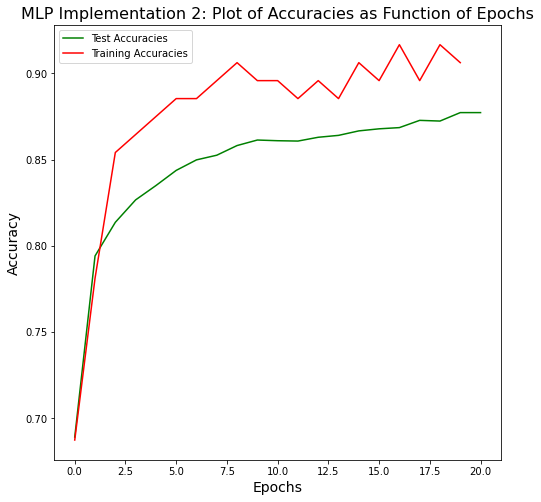

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion_normalized.shape[1], 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
loss=Loss_CategoricalCrossentropy(),
optimizer=Optimizer_SGD(learning_rate=0.1),
accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=128, print_every=100)
model.evaluate(X_test_fashion_normalized, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()

## **Main Implementation 1: Part 2: MLP with 2 hidden layers.**

### Leaky ReLU activation function

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, self.alpha) 
        return np.maximum(0, x) + self.alpha * np.minimum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
# Hyper-parameters
epochs = 250
batch_size = 256
lr = 1e-2

alpha_choices = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
accuracies = []

for alpha in alpha_choices:
    mlp_leaky = MLP(
        # First Layer
        LinearLayer(n_features, K1),
        LeakyReLULayer(alpha),
        # Second Layer
        LinearLayer(K1, K2),
        LeakyReLULayer(alpha),
        # Output Layer
        LinearLayer(K2, n_classes),
        SoftmaxOutputLayer()
    )
    opt_leaky = GradientDescentOptimizer(mlp_leaky, lr)

    mlp_leaky.fit(opt_leaky, X_train_fashion_std, y_train_fashion, epochs, batch_size, showplot=False)

    # Performance on Train dataset
    yh_train = mlp_leaky.predict(X_train_fashion_std)
    acc_train = evaluate_acc(y_train_fashion, yh_train)

    # Performance on Test dataset
    yh_test = mlp_leaky.predict(X_test_fashion_std)
    acc_test = evaluate_acc(y_test_fashion, yh_test)

    accuracies.append((acc_train, acc_test))

print(alpha_choices)
print(accuracies)

100%|██████████| 250/250 [01:04<00:00,  3.90it/s]


100%|██████████| 250/250 [01:06<00:00,  3.74it/s]


100%|██████████| 250/250 [01:05<00:00,  3.84it/s]


100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


100%|██████████| 250/250 [01:01<00:00,  4.04it/s]


100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


[0.001, 0.01, 0.05, 0.1, 0.5, 1]
[(0.7540666666666667, 0.7385), (0.7648333333333334, 0.7476), (0.7794666666666666, 0.7558), (0.79225, 0.7782), (0.7811666666666667, 0.7679), (0.7711, 0.7573)]


100%|██████████| 1250/1250 [05:01<00:00,  4.15it/s]


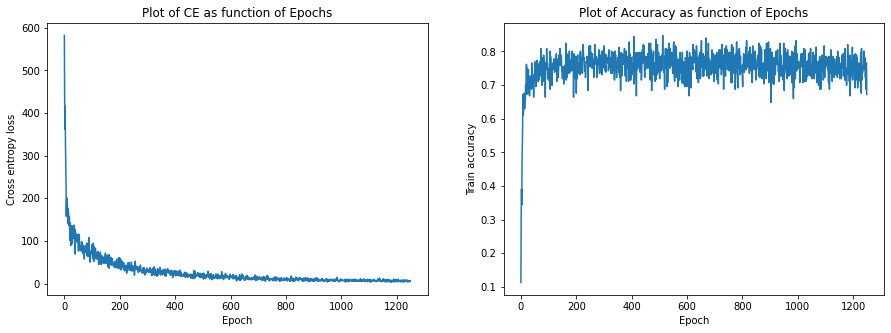

In [ ]:
# Number of neurons
K1 = 128    # Layer 1
K2 = 128    # Layer 2

# Hyper-parameters
epochs = 1250
batch_size = 256
lr = 1e-2
alpha = 0.01

mlp_leaky = MLP(
    # First Layer
    LinearLayer(n_features, K1),
    LeakyReLULayer(alpha),
    # Second Layer
    LinearLayer(K1, K2),
    LeakyReLULayer(alpha),
    # Output Layer
    LinearLayer(K2, n_classes),
    SoftmaxOutputLayer()
)
opt_leaky = GradientDescentOptimizer(mlp_leaky, lr)

mlp_leaky.fit(opt_leaky, X_train_fashion_std, y_train_fashion, epochs, batch_size, showplot=True)

In [ ]:
# Performance on Train dataset
yh_train = mlp_leaky.predict(X_train_fashion_std)
print("Train accuracy:", evaluate_acc(y_train_fashion, yh_train))

# Performance on Test dataset
yh_test = mlp_leaky.predict(X_test_fashion_std)
print("Test accuracy:", evaluate_acc(y_test_fashion, yh_test))

Train accuracy: 0.7700333333333333
Train accuracy: 0.7491


### Tanh activation function

In [ ]:
class TanhLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        tanh = np.tanh(x)
        self.gradient = 1 - (tanh ** 2)
        return tanh

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

100%|██████████| 2500/2500 [09:27<00:00,  4.40it/s]


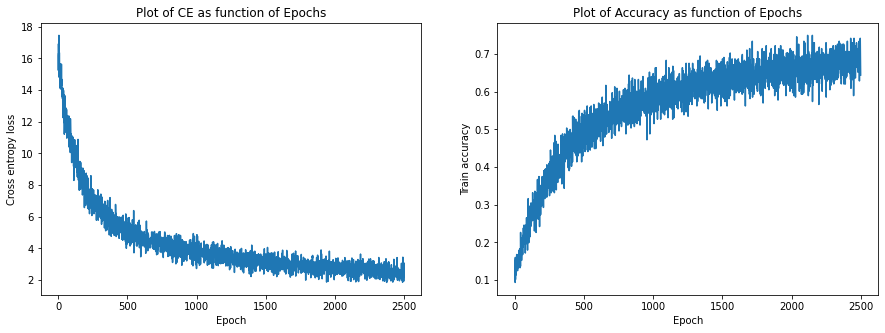

In [ ]:
# Number of neurons
K1 = 128    # Layer 1
K2 = 128    # Layer 2

# Hyper-parameters
epochs = 2500
batch_size = 256
lr = 1e-1

mlp_tanh = MLP(
    # First Layer
    LinearLayer(n_features, K1),
    TanhLayer(),
    # Second Layer
    LinearLayer(K1, K2),
    TanhLayer(),
    # Output Layer
    LinearLayer(K2, n_classes),
    SoftmaxOutputLayer()
)
opt_tanh = GradientDescentOptimizer(mlp_tanh, lr)

mlp_tanh.fit(opt_tanh, X_train_fashion_std, y_train_fashion, epochs, batch_size, showplot=True)

In [ ]:
# Performance on Train dataset
yh_train = mlp_tanh.predict(X_train_fashion_std)
print("Train accuracy:", evaluate_acc(y_train_fashion, yh_train))

# Performance on Test dataset
yh_test = mlp_tanh.predict(X_test_fashion_std)
print("Test accuracy:", evaluate_acc(y_test_fashion, yh_test))

Train accuracy: 0.6775333333333333
Test accuracy: 0.6167


## **Implementation 2: Part 2: MLP with 2 hidden layers.**

### Tanh activation function

epoch: 1
step: 0, acc: 0.156, loss: 2.302 (data_loss: 2.302, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.297, loss: 1.803 (data_loss: 1.803, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.586, loss: 1.035 (data_loss: 1.035, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.648, loss: 0.851 (data_loss: 0.851, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.672, loss: 0.813 (data_loss: 0.813, reg_loss: 0.000), lr: 0.1
step: 468, acc: 0.750, loss: 0.655 (data_loss: 0.655, reg_loss: 0.000), lr: 0.1
training, acc: 0.524, loss: 1.270 (data_loss: 1.270, reg_loss: 0.000), lr: 0.1
validation, acc: 0.726, loss: 0.729
epoch: 2
step: 0, acc: 0.781, loss: 0.656 (data_loss: 0.656, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.812, loss: 0.522 (data_loss: 0.522, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.773, loss: 0.527 (data_loss: 0.527, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.820, loss: 0.536 (data_loss: 0.536, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.734, loss: 0.658 (data_loss: 0.658, reg_loss: 0.000),

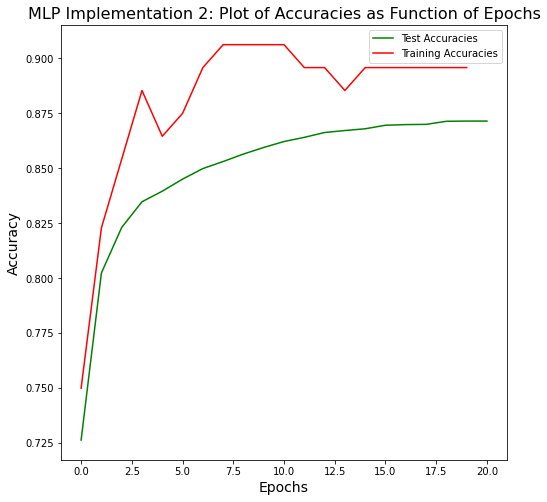

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion_normalized.shape[1], 128))
model.add(Activation_Tanh())
model.add(Layer_Dense(128, 128))
model.add(Activation_Tanh())
model.add(Layer_Dense(128, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
loss=Loss_CategoricalCrossentropy(),
optimizer=Optimizer_SGD(learning_rate=0.1),
accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=128, print_every=100)
model.evaluate(X_test_fashion_normalized, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()

### Leaky ReLU activation function

epoch: 1
step: 0, acc: 0.039, loss: 2.303 (data_loss: 2.303, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.109, loss: 2.290 (data_loss: 2.290, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.414, loss: 1.316 (data_loss: 1.316, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.547, loss: 1.212 (data_loss: 1.212, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.625, loss: 0.867 (data_loss: 0.867, reg_loss: 0.000), lr: 0.1
step: 468, acc: 0.740, loss: 0.807 (data_loss: 0.807, reg_loss: 0.000), lr: 0.1
training, acc: 0.443, loss: 1.483 (data_loss: 1.483, reg_loss: 0.000), lr: 0.1
validation, acc: 0.699, loss: 0.821
epoch: 2
step: 0, acc: 0.758, loss: 0.687 (data_loss: 0.687, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.734, loss: 0.644 (data_loss: 0.644, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.750, loss: 0.618 (data_loss: 0.618, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.766, loss: 0.594 (data_loss: 0.594, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.742, loss: 0.660 (data_loss: 0.660, reg_loss: 0.000),

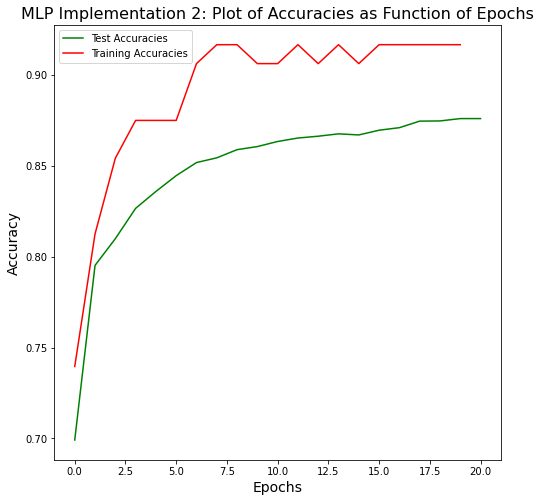

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion_normalized.shape[1], 128))
model.add(Activation_Leaky_ReLU(alpha=0.1))
model.add(Layer_Dense(128, 128))
model.add(Activation_Leaky_ReLU(alpha=0.1))
model.add(Layer_Dense(128, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_SGD(learning_rate=0.1),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=128, print_every=100)
model.evaluate(X_test_fashion_normalized, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()

## **Implementation 1 and 2: Part 3 - MLP with 2 hidden layers, ReLU activations, and L2 regularization.**

### MLP Implementation 1

In [ ]:
# Number of features & classes
n_features = 784
n_classes = 10

# Hyper-parameters
batch_size = 256
lr = 1e-2

# Number of neurons
K1 = 128    # Layer 1
K2 = 128    # Layer 2

In [ ]:
train_acc_relu_no_l2 = []
test_acc_relu_no_l2 = []
epoch_value = []

for epoch_selected in range(100, 501, 100):
  mlp_relu = MLP(
      # First Layer
      LinearLayer(n_features, K1),
      ReLULayer(),
      # Second Layer
      LinearLayer(K1, K2),
      ReLULayer(),
      # Output Layer
      LinearLayer(K2, n_classes),
      SoftmaxOutputLayer()
  )

  opt_relu = GradientDescentOptimizer(mlp_relu, lr)

  mlp_relu.fit(opt_relu, X_train_fashion_normalized, y_train_fashion, epoch_selected, batch_size, showplot=False)

  # Performance on Train dataset
  yh_train_data = mlp_relu.predict(X_train_fashion_normalized)
  train_acc = evaluate_acc(y_train_fashion, yh_train_data)

  # Performance on Test dataset
  yh_test_data = mlp_relu.predict(X_test_fashion_normalized)
  test_acc = evaluate_acc(y_test_fashion, yh_test_data)

  train_acc_relu_no_l2.append(train_acc)
  test_acc_relu_no_l2.append(test_acc)
  epoch_value.append(epoch_selected)



100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


100%|██████████| 200/200 [00:54<00:00,  3.66it/s]


100%|██████████| 300/300 [01:24<00:00,  3.55it/s]


100%|██████████| 400/400 [01:42<00:00,  3.89it/s]


100%|██████████| 500/500 [02:02<00:00,  4.07it/s]


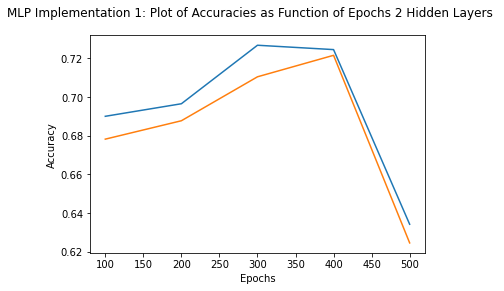

In [ ]:
plt.plot(epoch_value, train_acc_relu_no_l2)
plt.plot(epoch_value, test_acc_relu_no_l2)
plt.suptitle('MLP Implementation 1: Plot of Accuracies as Function of Epochs 2 Hidden Layers ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

100%|██████████| 350/350 [01:27<00:00,  3.99it/s]


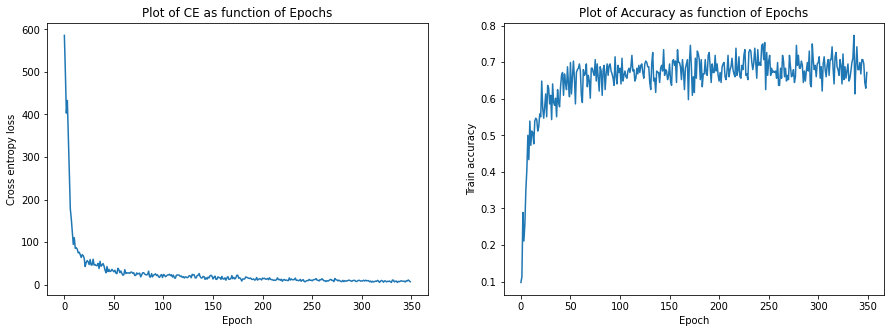

In [ ]:
epochs = 350
mlp_relu_without_l2 = MLP(
    # First Layer
    LinearLayer(n_features, K1),
    ReLULayer(),
    # Second Layer
    LinearLayer(K1, K2),
    ReLULayer(),
    # Output Layer
    LinearLayer(K2, n_classes),
    SoftmaxOutputLayer()
)

opt_relu_without_l2 = GradientDescentOptimizer(mlp_relu_without_l2, lr)

mlp_relu_without_l2.fit(opt_relu_without_l2, X_train_fashion_normalized, y_train_fashion, epochs, batch_size, showplot=True)

In [ ]:
# Performance on Train dataset
yh_train = mlp_relu_without_l2.predict(X_train_fashion_normalized)
print("Train accuracy:", evaluate_acc(y_train_fashion, yh_train))

# Performance on Test dataset
yh_test = mlp_relu_without_l2.predict(X_test_fashion_normalized)
print("Test accuracy:", evaluate_acc(y_test_fashion, yh_test))

Train accuracy: 0.6954833333333333
Test accuracy: 0.6805


In [ ]:
# Optimizing L2 Lambda
train_acc_relu = []
test_acc_relu = []
l2_value = []
epoch_selected = 350

for l2 in range(10, 101, 10):
  l2_regularization_weight_value = l2/100

  mlp_relu_l2_opt = MLP(
      # First Layer
      LinearLayer(n_features, K1, l2_regularization_weight=l2_regularization_weight_value),
      ReLULayer(),
      # Second Layer
      LinearLayer(K1, K2, l2_regularization_weight=l2_regularization_weight_value),
      ReLULayer(),
      # Output Layer
      LinearLayer(K2, n_classes, l2_regularization_weight=l2_regularization_weight_value),
      SoftmaxOutputLayer()
  )

  opt_relu_l2_opt = GradientDescentOptimizer(mlp_relu_l2_opt, lr)

  mlp_relu_l2_opt.fit(opt_relu_l2_opt, X_train_fashion_normalized, y_train_fashion, epoch_selected, batch_size, showplot=False)

  # Performance on Train dataset
  yh_train_data = mlp_relu_l2_opt.predict(X_train_fashion_normalized)
  train_acc = evaluate_acc(y_train_fashion, yh_train_data)

  # Performance on Test dataset
  yh_test_data = mlp_relu_l2_opt.predict(X_test_fashion_normalized)
  test_acc = evaluate_acc(y_test_fashion, yh_test_data)

  train_acc_relu.append(train_acc)
  test_acc_relu.append(test_acc)
  l2_value.append(l2_regularization_weight_value)



100%|██████████| 350/350 [01:34<00:00,  3.69it/s]


100%|██████████| 350/350 [01:31<00:00,  3.85it/s]


100%|██████████| 350/350 [01:30<00:00,  3.86it/s]


100%|██████████| 350/350 [01:38<00:00,  3.57it/s]


100%|██████████| 350/350 [01:30<00:00,  3.87it/s]


100%|██████████| 350/350 [01:31<00:00,  3.81it/s]


100%|██████████| 350/350 [01:33<00:00,  3.76it/s]


100%|██████████| 350/350 [01:30<00:00,  3.87it/s]


100%|██████████| 350/350 [01:30<00:00,  3.85it/s]


100%|██████████| 350/350 [01:33<00:00,  3.76it/s]


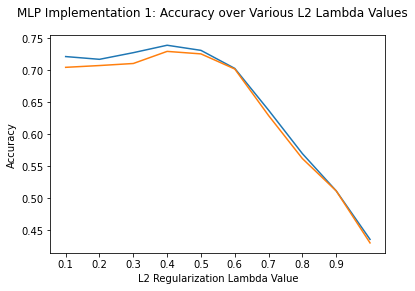

In [ ]:
plt.xticks(np.arange(0, 1, 0.1))
plt.plot(l2_value, train_acc_relu)
plt.plot(l2_value, test_acc_relu)
plt.suptitle('MLP Implementation 1: Accuracy over Various L2 Lambda Values')
plt.xlabel('L2 Regularization Lambda Value')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
train_acc_relu_with_l2 = []
test_acc_relu_with_l2 = []
epoch_value = []

l2_regularization_weight_value = 0.4

for epoch_selected in range(100, 501, 100):
  mlp_relu = MLP(
      # First Layer
      LinearLayer(n_features, K1, l2_regularization_weight=l2_regularization_weight_value),
      ReLULayer(),
      # Second Layer
      LinearLayer(K1, K2, l2_regularization_weight=l2_regularization_weight_value),
      ReLULayer(),
      # Output Layer
      LinearLayer(K2, n_classes, l2_regularization_weight=l2_regularization_weight_value),
      SoftmaxOutputLayer()
  )

  opt_relu = GradientDescentOptimizer(mlp_relu, lr)

  mlp_relu.fit(opt_relu, X_train_fashion_normalized, y_train_fashion, epoch_selected, batch_size, showplot=False)

  # Performance on Train dataset
  yh_train_data = mlp_relu.predict(X_train_fashion_normalized)
  train_acc = evaluate_acc(y_train_fashion, yh_train_data)

  # Performance on Test dataset
  yh_test_data = mlp_relu.predict(X_test_fashion_normalized)
  test_acc = evaluate_acc(y_test_fashion, yh_test_data)

  train_acc_relu_with_l2.append(train_acc)
  test_acc_relu_with_l2.append(test_acc)
  epoch_value.append(epoch_selected)



100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


100%|██████████| 200/200 [00:54<00:00,  3.65it/s]


100%|██████████| 300/300 [01:15<00:00,  3.98it/s]


100%|██████████| 400/400 [01:54<00:00,  3.50it/s]


100%|██████████| 500/500 [02:10<00:00,  3.83it/s]


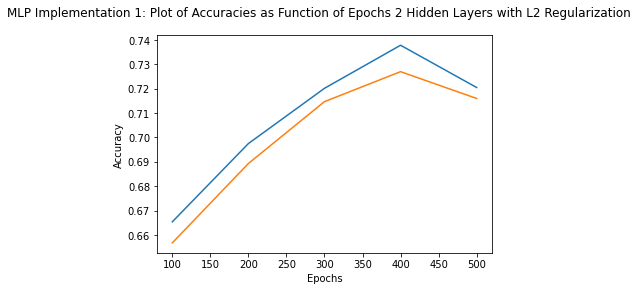

In [ ]:
plt.plot(epoch_value, train_acc_relu_with_l2)
plt.plot(epoch_value, test_acc_relu_with_l2)
plt.suptitle('MLP Implementation 1: Plot of Accuracies as Function of Epochs 2 Hidden Layers with L2 Regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

100%|██████████| 400/400 [01:48<00:00,  3.69it/s]


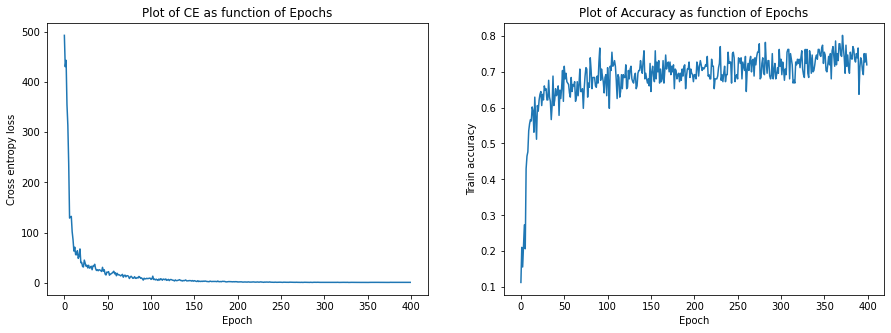

In [ ]:
epochs = 400

mlp_relu_with_l2 = MLP(
    # First Layer
    LinearLayer(n_features, K1, l2_regularization_weight=l2_regularization_weight_value),
    ReLULayer(),
    # Second Layer
    LinearLayer(K1, K2, l2_regularization_weight=l2_regularization_weight_value),
    ReLULayer(),
    # Output Layer
    LinearLayer(K2, n_classes, l2_regularization_weight=l2_regularization_weight_value),
    SoftmaxOutputLayer()
)

opt_relu_with_l2 = GradientDescentOptimizer(mlp_relu_with_l2, lr)

mlp_relu_with_l2.fit(opt_relu_with_l2, X_train_fashion_normalized, y_train_fashion, epochs, batch_size, showplot=True)

In [ ]:
# Performance on Train dataset
yh_train = mlp_relu_with_l2.predict(X_train_fashion_normalized)
print("Train accuracy:", evaluate_acc(y_train_fashion, yh_train))

# Performance on Test dataset
yh_test = mlp_relu_with_l2.predict(X_test_fashion_normalized)
print("Test accuracy:", evaluate_acc(y_test_fashion, yh_test))

Train accuracy: 0.7283833333333334
Test accuracy: 0.7227


### MLP Implementation 2

epoch: 1
step: 0, acc: 0.047, loss: 2.320 (data_loss: 2.303, reg_loss: 0.018), lr: 0.1
step: 100, acc: 0.094, loss: 2.309 (data_loss: 2.297, reg_loss: 0.013), lr: 0.1
step: 200, acc: 0.281, loss: 1.546 (data_loss: 1.498, reg_loss: 0.049), lr: 0.1
step: 300, acc: 0.594, loss: 1.187 (data_loss: 1.089, reg_loss: 0.098), lr: 0.1
step: 400, acc: 0.586, loss: 1.136 (data_loss: 1.013, reg_loss: 0.123), lr: 0.1
step: 468, acc: 0.562, loss: 1.165 (data_loss: 1.035, reg_loss: 0.130), lr: 0.1
training, acc: 0.386, loss: 1.735 (data_loss: 1.604, reg_loss: 0.130), lr: 0.1
validation, acc: 0.654, loss: 0.953
epoch: 2
step: 0, acc: 0.719, loss: 0.986 (data_loss: 0.856, reg_loss: 0.130), lr: 0.1
step: 100, acc: 0.703, loss: 0.896 (data_loss: 0.761, reg_loss: 0.135), lr: 0.1
step: 200, acc: 0.578, loss: 0.970 (data_loss: 0.833, reg_loss: 0.137), lr: 0.1
step: 300, acc: 0.703, loss: 0.911 (data_loss: 0.771, reg_loss: 0.140), lr: 0.1
step: 400, acc: 0.734, loss: 0.879 (data_loss: 0.735, reg_loss: 0.144),

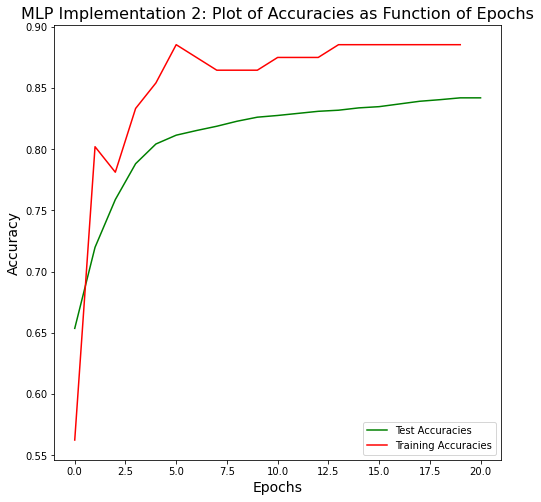

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion_normalized.shape[1], 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 128, weight_regularizer_l2=0.01, bias_regularizer_l2=0.01))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 10, weight_regularizer_l2=0.01, bias_regularizer_l2=0.01))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
loss=Loss_CategoricalCrossentropy(),
optimizer=Optimizer_SGD(learning_rate=0.1),
accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=128, print_every=100)
model.evaluate(X_test_fashion_normalized, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()

## **Main Implementation 1: Part 4 - MLP with 2 hidden layers, ReLU activation, on unnormalized dataset.**

In [ ]:
train_acc_relu_unnormalized = []
test_acc_relu_unnormalized = []
epoch_value = []

for epoch_selected in range(100, 501, 100):
  mlp_relu = MLP(
      # First Layer
      LinearLayer(n_features, K1),
      ReLULayer(),
      # Second Layer
      LinearLayer(K1, K2),
      ReLULayer(),
      # Output Layer
      LinearLayer(K2, n_classes),
      SoftmaxOutputLayer()
  )

  opt_relu = GradientDescentOptimizer(mlp_relu, lr=1e-6)

  mlp_relu.fit(opt_relu, X_train_fashion, y_train_fashion, epoch_selected, batch_size, showplot=False)

  # Performance on Train dataset
  yh_train_data = mlp_relu.predict(X_train_fashion)
  train_acc = evaluate_acc(y_train_fashion, yh_train_data)

  # Performance on Test dataset
  yh_test_data = mlp_relu.predict(X_test_fashion)
  test_acc = evaluate_acc(y_test_fashion, yh_test_data)

  train_acc_relu_unnormalized.append(train_acc)
  test_acc_relu_unnormalized.append(test_acc)
  epoch_value.append(epoch_selected)



100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


100%|██████████| 300/300 [01:07<00:00,  4.46it/s]


100%|██████████| 400/400 [01:28<00:00,  4.50it/s]


100%|██████████| 500/500 [01:52<00:00,  4.44it/s]


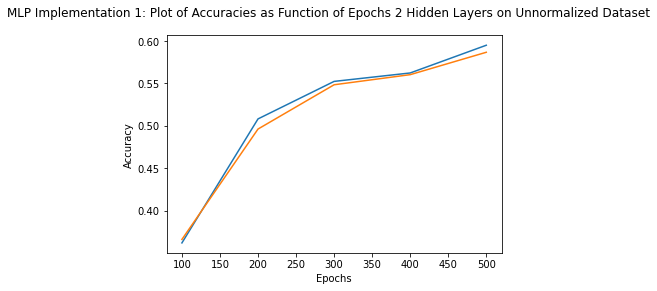

In [ ]:
plt.plot(epoch_value, train_acc_relu_unnormalized)
plt.plot(epoch_value, test_acc_relu_unnormalized)
plt.suptitle('MLP Implementation 1: Plot of Accuracies as Function of Epochs 2 Hidden Layers on Unnormalized Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

100%|██████████| 500/500 [01:54<00:00,  4.35it/s]


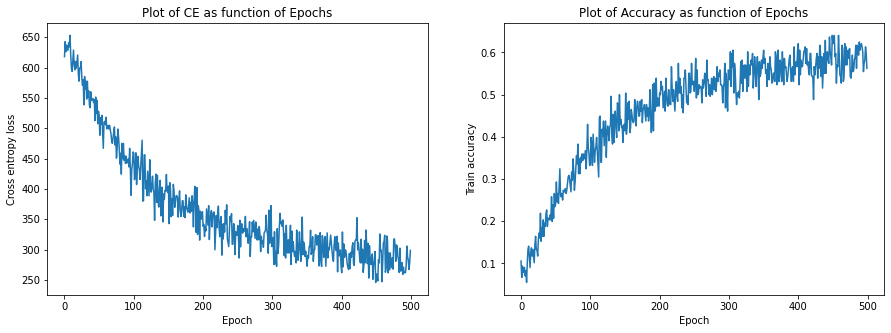

In [ ]:
epochs = 500

mlp_relu_unnormalized = MLP(
    # First Layer
    LinearLayer(n_features, K1),
    ReLULayer(),
    # Second Layer
    LinearLayer(K1, K2),
    ReLULayer(),
    # Output Layer
    LinearLayer(K2, n_classes),
    SoftmaxOutputLayer()
)

opt_relu_unnormalized = GradientDescentOptimizer(mlp_relu_unnormalized, lr=1e-6)

mlp_relu_unnormalized.fit(opt_relu_unnormalized, X_train_fashion, y_train_fashion, epochs, batch_size, showplot=True)

In [ ]:
# Performance on Train dataset
yh_train_unnormalized = mlp_relu_unnormalized.predict(X_train_fashion)
print("Train accuracy:", evaluate_acc(y_train_fashion, yh_train_unnormalized))

# Performance on Test dataset
yh_test_unnormalized = mlp_relu_unnormalized.predict(X_test_fashion)
print("Test accuracy:", evaluate_acc(y_test_fashion, yh_test_unnormalized))

Train accuracy: 0.59765
Test accuracy: 0.5939


## **Implementation 2: Part 4 - MLP with 2 hidden layers, ReLU activation, on unnormalized dataset.**

epoch: 1
step: 0, acc: 0.070, loss: 2.347 (data_loss: 2.347, reg_loss: 0.000), lr: 0.01
step: 100, acc: 0.766, loss: 0.542 (data_loss: 0.542, reg_loss: 0.000), lr: 0.01
step: 200, acc: 0.766, loss: 0.532 (data_loss: 0.532, reg_loss: 0.000), lr: 0.01
step: 300, acc: 0.836, loss: 0.432 (data_loss: 0.432, reg_loss: 0.000), lr: 0.01
step: 400, acc: 0.773, loss: 0.608 (data_loss: 0.608, reg_loss: 0.000), lr: 0.01
step: 468, acc: 0.854, loss: 0.528 (data_loss: 0.528, reg_loss: 0.000), lr: 0.01
training, acc: 0.752, loss: 0.666 (data_loss: 0.666, reg_loss: 0.000), lr: 0.01
validation, acc: 0.817, loss: 0.513
epoch: 2
step: 0, acc: 0.844, loss: 0.383 (data_loss: 0.383, reg_loss: 0.000), lr: 0.01
step: 100, acc: 0.828, loss: 0.421 (data_loss: 0.421, reg_loss: 0.000), lr: 0.01
step: 200, acc: 0.812, loss: 0.375 (data_loss: 0.375, reg_loss: 0.000), lr: 0.01
step: 300, acc: 0.852, loss: 0.378 (data_loss: 0.378, reg_loss: 0.000), lr: 0.01
step: 400, acc: 0.797, loss: 0.499 (data_loss: 0.499, reg_lo

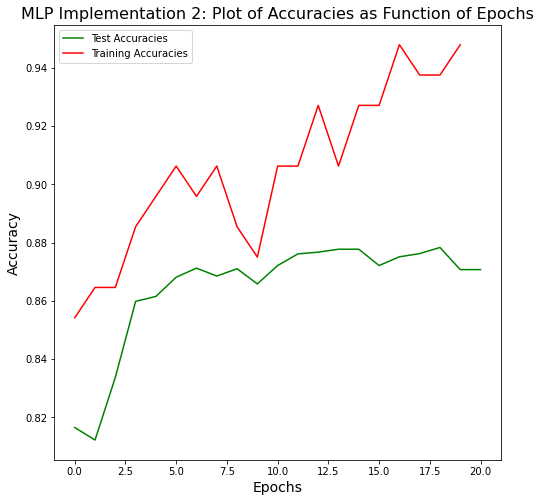

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion.shape[1], 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_SGD(learning_rate=0.01),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion, y_train_fashion, validation_data=(X_test_fashion, y_test_fashion),
epochs=20, batch_size=128, print_every=100)
model.evaluate(X_test_fashion, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()

## **Part 5 - CNN with 2 convolutional, 2 fully connected layers, and ReLU activations.**

In [ ]:
# Normalizing and reshaping the data
# First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5]. 
# Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
X_train_fashion_normalized_cnn = (X_train_fashion_original / 255) - 0.5
X_test_fashion_normalized_cnn = (X_test_fashion_original / 255) - 0.5

print(X_train_fashion_normalized_cnn.shape) # (60000, 28, 28)
print(X_test_fashion_normalized_cnn.shape)  # (10000, 28, 28)

# Reshape the images.
X_train_fashion_normalized_cnn = np.expand_dims(X_train_fashion_normalized_cnn, axis=3)
X_test_fashion_normalized_cnn = np.expand_dims(X_test_fashion_normalized_cnn, axis=3)

print(X_train_fashion_normalized_cnn.shape) # (60000, 28, 28, 1)
print(X_test_fashion_normalized_cnn.shape)  # (10000, 28, 28, 1)

y_train_fashion_cnn = keras.utils.np_utils.to_categorical(y_train_fashion_original)
y_test_fashion_cnn = keras.utils.np_utils.to_categorical(y_test_fashion_original)
print(y_train_fashion_cnn.shape) # (60000, 10)
print(y_test_fashion_cnn.shape)  # (10000, 10)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


### CNN Experiment

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
optimizer = keras.optimizers.SGD(lr=0.1)
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
# model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers
cnn_model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
cnn_model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model.add(Dense(128, activation='relu')) # fully connected layer
cnn_model.add(Dense(num_classes, activation='softmax')) # output layer

In [ ]:
# Summary of the model 
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 flatten_8 (Flatten)         (None, 36864)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               4718720   
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
Total params: 4,738,826
Trainable params: 4,738,826
No

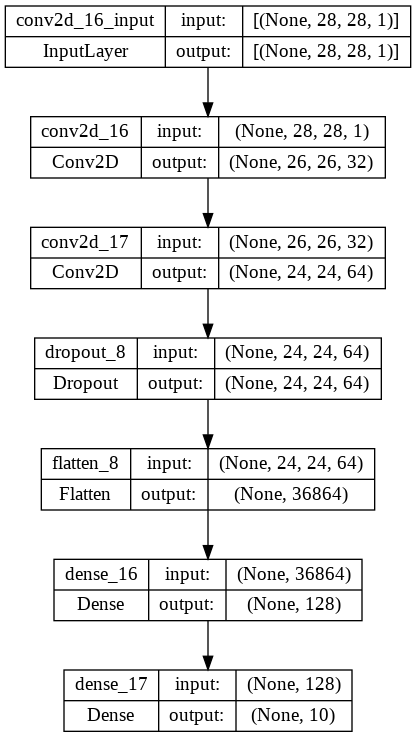

In [ ]:
# Plot model 
keras.utils.plot_model(cnn_model, "my_mnist_model.png", show_shapes=True)

In [ ]:
# Compile the model
cnn_model.compile(
  optimizer=optimizer,                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 20

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# Fitting the model
history = cnn_model.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8312
Epoch 1: val_loss improved from inf to 0.37872, saving model to mnist_best_model.hdf5
938/938 [==============================] - 186s 198ms/step - loss: 0.4612 - accuracy: 0.8312 - val_loss: 0.3787 - val_accuracy: 0.8587
Epoch 2/20
938/938 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8895
Epoch 2: val_loss improved from 0.37872 to 0.33805, saving model to mnist_best_model.hdf5
938/938 [==============================] - 179s 190ms/step - loss: 0.3008 - accuracy: 0.8895 - val_loss: 0.3381 - val_accuracy: 0.8757
Epoch 3/20
938/938 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9062
Epoch 3: val_loss improved from 0.33805 to 0.30352, saving model to mnist_best_model.hdf5
938/938 [==============================] - 183s 195ms/step - loss: 0.2540 - accuracy: 0.9062 - val_loss: 0.3035 - val_accuracy: 0.8865
Epoch 4/20
938/938 [=====================

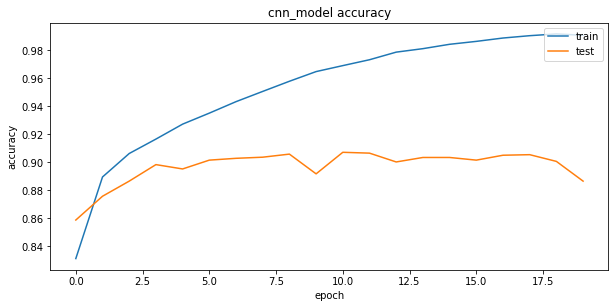

In [ ]:
# plot training history
plt.figure(figsize=(10,10))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

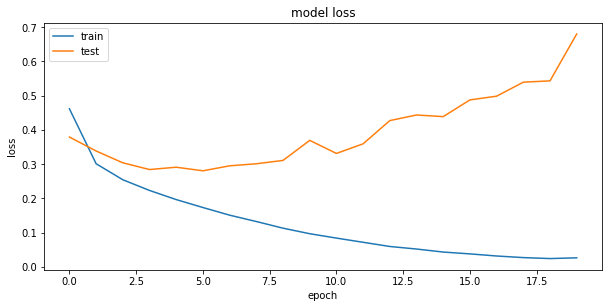

In [ ]:
plt.figure(figsize=(10, 10))

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

313/313 [==============================] - 10s 32ms/step
Test error: 11.3%


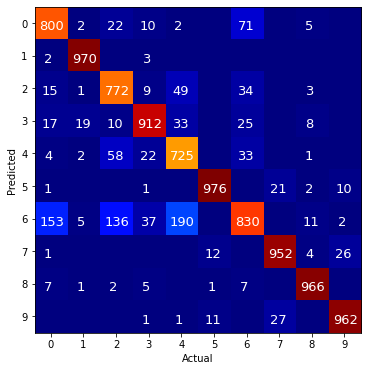

In [ ]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(cnn_model.predict(X_test_fashion_normalized_cnn),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test_fashion_cnn,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=13, color='white')

In [ ]:
accuracy = np.sum(y_test_fashion_original == test_predictions) / len(y_test_fashion_original)
accuracy

0.8865

## **Part 6 -  Best-performing MLP architecture.**

### MLP Implementation 2

epoch: 1
step: 0, acc: 0.100, loss: 2.303 (data_loss: 2.303, reg_loss: 0.000), lr: 0.1
step: 100, acc: 0.467, loss: 1.320 (data_loss: 1.320, reg_loss: 0.000), lr: 0.1
step: 200, acc: 0.550, loss: 0.962 (data_loss: 0.962, reg_loss: 0.000), lr: 0.1
step: 300, acc: 0.617, loss: 1.110 (data_loss: 1.110, reg_loss: 0.000), lr: 0.1
step: 400, acc: 0.517, loss: 1.203 (data_loss: 1.203, reg_loss: 0.000), lr: 0.1
step: 500, acc: 0.817, loss: 0.499 (data_loss: 0.499, reg_loss: 0.000), lr: 0.1
step: 600, acc: 0.700, loss: 0.675 (data_loss: 0.675, reg_loss: 0.000), lr: 0.1
step: 700, acc: 0.800, loss: 0.626 (data_loss: 0.626, reg_loss: 0.000), lr: 0.1
step: 800, acc: 0.850, loss: 0.495 (data_loss: 0.495, reg_loss: 0.000), lr: 0.1
step: 900, acc: 0.767, loss: 0.500 (data_loss: 0.500, reg_loss: 0.000), lr: 0.1
step: 999, acc: 0.767, loss: 0.657 (data_loss: 0.657, reg_loss: 0.000), lr: 0.1
training, acc: 0.693, loss: 0.840 (data_loss: 0.840, reg_loss: 0.000), lr: 0.1
validation, acc: 0.781, loss: 0.61

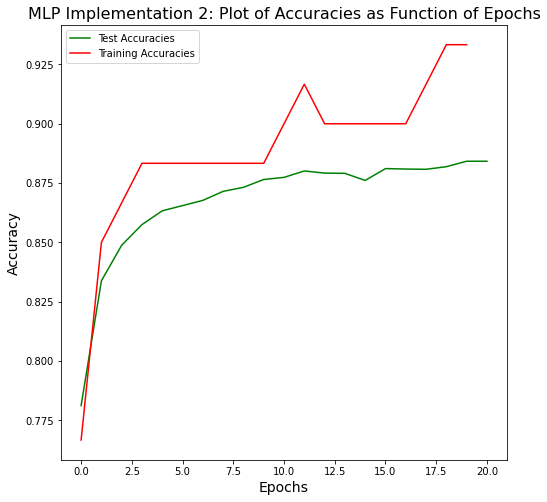

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion_normalized.shape[1], 512))
model.add(Activation_ReLU())
model.add(Layer_Dense(512, 512))
model.add(Activation_ReLU())
model.add(Layer_Dense(512, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
loss=Loss_CategoricalCrossentropy(),
optimizer=Optimizer_SGD(learning_rate=0.1),
accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=60, print_every=100)
model.evaluate(X_test_fashion_normalized, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()

### MLP Implementation 1

In [ ]:
# Hyper-parameters
epochs = 250
lr = 1e-2
alpha = 0.1

batch_sizes = [64, 256, 512, 512]
K_sizes = [64, 128, 128, 60]

# ReLU
accuracies1 = []
for batch_size, K in zip(batch_sizes, K_sizes):
    mlp6 = MLP(
        # First Layer
        LinearLayer(n_features, K),
        ReLULayer(),
        # Second Layer
        LinearLayer(K, K),
        ReLULayer(),
        # Output Layer
        LinearLayer(K, n_classes),
        SoftmaxOutputLayer()
    )
    opt6 = GradientDescentOptimizer(mlp6, lr)

    mlp6.fit(opt6, X_train_fashion_std, y_train_fashion, epochs, batch_size, showplot=False)

    # Performance on Test dataset
    yh_test = mlp6.predict(X_test_fashion_std)
    accuracies1.append(evaluate_acc(y_test_fashion, yh_test))

print([(batch_size, K) for batch_size, K in zip(batch_sizes, K_sizes)])
print(accuracies1)

# ReLU
accuracies2 = []
for batch_size, K in zip(batch_sizes, K_sizes):
    mlp6 = MLP(
        # First Layer
        LinearLayer(n_features, K),
        LeakyReLULayer(alpha),
        # Second Layer
        LinearLayer(K, K),
        LeakyReLULayer(alpha),
        # Output Layer
        LinearLayer(K, n_classes),
        SoftmaxOutputLayer()
    )
    opt6 = GradientDescentOptimizer(mlp6, lr)

    mlp6.fit(opt6, X_train_fashion_std, y_train_fashion, epochs, batch_size, showplot=False)

    # Performance on Test dataset
    yh_test = mlp6.predict(X_test_fashion_std)
    accuracies2.append(evaluate_acc(y_test_fashion, yh_test))

print([(batch_size, K) for batch_size, K in zip(batch_sizes, K_sizes)])
print(accuracies2)

100%|██████████| 250/250 [00:13<00:00, 19.21it/s]


100%|██████████| 250/250 [01:00<00:00,  4.17it/s]


100%|██████████| 250/250 [01:36<00:00,  2.58it/s]


100%|██████████| 250/250 [00:48<00:00,  5.13it/s]


[(64, 64), (256, 128), (512, 128), (512, 60)]
[0.6637, 0.7445, 0.7512, 0.6769]



100%|██████████| 250/250 [00:09<00:00, 25.90it/s]


100%|██████████| 250/250 [01:09<00:00,  3.61it/s]


100%|██████████| 250/250 [01:51<00:00,  2.24it/s]


100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


[(64, 64), (256, 128), (512, 128), (512, 60)]
[0.6895, 0.7506, 0.7642, 0.7233]


## **Part 7 - CNN Experiments.**

In [ ]:
# Normalizing and reshaping the data
# First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5]. 
# Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
X_train_fashion_normalized_cnn = (X_train_fashion_original / 255) - 0.5
X_test_fashion_normalized_cnn = (X_test_fashion_original / 255) - 0.5

print(X_train_fashion_normalized_cnn.shape) # (60000, 28, 28)
print(X_test_fashion_normalized_cnn.shape)  # (10000, 28, 28)

# Reshape the images.
X_train_fashion_normalized_cnn = np.expand_dims(X_train_fashion_normalized_cnn, axis=3)
X_test_fashion_normalized_cnn = np.expand_dims(X_test_fashion_normalized_cnn, axis=3)

print(X_train_fashion_normalized_cnn.shape) # (60000, 28, 28, 1)
print(X_test_fashion_normalized_cnn.shape)  # (10000, 28, 28, 1)

y_train_fashion_cnn = keras.utils.np_utils.to_categorical(y_train_fashion_original)
y_test_fashion_cnn = keras.utils.np_utils.to_categorical(y_test_fashion_original)
print(y_train_fashion_cnn.shape) # (60000, 10)
print(y_test_fashion_cnn.shape)  # (10000, 10)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


### Experiment 1

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
cnn_model_1 = Sequential()
cnn_model_1.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
cnn_model_1.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
cnn_model_1.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model_1.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model_1.add(Dense(128, activation='relu')) # fully connected layer
cnn_model_1.add(Dense(num_classes, activation='softmax')) # output layer

# Compile the model
cnn_model_1.compile(
  'Adam',                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

# Fitting the model
history = cnn_model_1.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=5,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

# Model predictions and confusion matrix
test_predictions          = np.argmax(cnn_model_1.predict(X_test_fashion_normalized_cnn),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test_fashion_cnn,1))
print('Test error: %.1f%%' % test_error)
accuracy = np.sum(y_test_fashion_original == test_predictions) / len(y_test_fashion_original)
accuracy

Epoch 1/5
938/938 [==============================] - ETA: 0s - loss: 0.3753 - accuracy: 0.8638
Epoch 1: val_loss did not improve from 0.28023
938/938 [==============================] - 197s 209ms/step - loss: 0.3753 - accuracy: 0.8638 - val_loss: 0.3066 - val_accuracy: 0.8874
Epoch 2/5
938/938 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.9082
Epoch 2: val_loss improved from 0.28023 to 0.27907, saving model to mnist_best_model.hdf5
938/938 [==============================] - 197s 210ms/step - loss: 0.2501 - accuracy: 0.9082 - val_loss: 0.2791 - val_accuracy: 0.8958
Epoch 3/5
938/938 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9275
Epoch 3: val_loss improved from 0.27907 to 0.27029, saving model to mnist_best_model.hdf5
938/938 [==============================] - 205s 218ms/step - loss: 0.1952 - accuracy: 0.9275 - val_loss: 0.2703 - val_accuracy: 0.9105
Epoch 4/5
938/938 [==============================] - ETA: 0s - loss: 0.1530 - accur

0.9041

### Experiment 2

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
cnn_model_2 = Sequential()
cnn_model_2.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
cnn_model_2.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
cnn_model_2.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model_2.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model_2.add(Dense(128, activation='relu')) # fully connected layer
cnn_model_2.add(Dense(num_classes, activation='softmax')) # output layer

# Compile the model
cnn_model_2.compile(
  'Adagrad',                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

# Fitting the model
history = cnn_model_2.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=5,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

# Model predictions and confusion matrix
test_predictions          = np.argmax(cnn_model_2.predict(X_test_fashion_normalized_cnn),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test_fashion_cnn,1))
print('Test error: %.1f%%' % test_error)
accuracy = np.sum(y_test_fashion_original == test_predictions) / len(y_test_fashion_original)
accuracy

Epoch 1/5
938/938 [==============================] - ETA: 0s - loss: 0.8763 - accuracy: 0.7140
Epoch 1: val_loss did not improve from 0.27029
938/938 [==============================] - 197s 210ms/step - loss: 0.8763 - accuracy: 0.7140 - val_loss: 0.6053 - val_accuracy: 0.7736
Epoch 2/5
938/938 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.8004
Epoch 2: val_loss did not improve from 0.27029
938/938 [==============================] - 193s 205ms/step - loss: 0.5505 - accuracy: 0.8004 - val_loss: 0.5667 - val_accuracy: 0.7926
Epoch 3/5
938/938 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.8174
Epoch 3: val_loss did not improve from 0.27029
938/938 [==============================] - 195s 208ms/step - loss: 0.5043 - accuracy: 0.8174 - val_loss: 0.5136 - val_accuracy: 0.8163
Epoch 4/5
938/938 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.8281
Epoch 4: val_loss did not improve from 0.27029
938/938 [==================

0.8277

### Experiment 3

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 2
padding     = 'same' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
cnn_model_3 = Sequential()
cnn_model_3.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
cnn_model_3.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
cnn_model_3.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model_3.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model_3.add(Dense(128, activation='relu')) # fully connected layer
cnn_model_3.add(Dense(num_classes, activation='softmax')) # output layer

# Compile the model
cnn_model_3.compile(
  'Adam',                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

# Fitting the model
history = cnn_model_3.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=5,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

# Model predictions and confusion matrix
test_predictions          = np.argmax(cnn_model_3.predict(X_test_fashion_normalized_cnn),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test_fashion_cnn,1))
print('Test error: %.1f%%' % test_error)
accuracy = np.sum(y_test_fashion_original == test_predictions) / len(y_test_fashion_original)
accuracy

Epoch 1/5
937/938 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.8487
Epoch 1: val_loss did not improve from 0.27029
938/938 [==============================] - 57s 60ms/step - loss: 0.4155 - accuracy: 0.8486 - val_loss: 0.3288 - val_accuracy: 0.8836
Epoch 2/5
937/938 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.8967
Epoch 2: val_loss did not improve from 0.27029
938/938 [==============================] - 56s 60ms/step - loss: 0.2797 - accuracy: 0.8968 - val_loss: 0.2985 - val_accuracy: 0.8924
Epoch 3/5
937/938 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9147
Epoch 3: val_loss improved from 0.27029 to 0.27029, saving model to mnist_best_model.hdf5
938/938 [==============================] - 56s 60ms/step - loss: 0.2300 - accuracy: 0.9147 - val_loss: 0.2703 - val_accuracy: 0.9019
Epoch 4/5
937/938 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9265
Epoch 4: val_loss did not improve fro

0.9062

### Experiment 4

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 2
padding     = 'same' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
cnn_model_4 = Sequential()
cnn_model_4.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
cnn_model_4.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
cnn_model_4.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model_4.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model_4.add(Dense(1000, activation='relu')) # fully connected layer
cnn_model_4.add(Dense(num_classes, activation='softmax')) # output layer

# Compile the model
cnn_model_4.compile(
  'Adam',                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

# Fitting the model
history = cnn_model_4.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=5,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

# Model predictions and confusion matrix
test_predictions          = np.argmax(cnn_model_4.predict(X_test_fashion_normalized_cnn),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test_fashion_cnn,1))
print('Test error: %.1f%%' % test_error)
accuracy = np.sum(y_test_fashion_original == test_predictions) / len(y_test_fashion_original)
accuracy

Epoch 1/5
938/938 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8643
Epoch 1: val_loss did not improve from 0.27029
938/938 [==============================] - 147s 156ms/step - loss: 0.3761 - accuracy: 0.8643 - val_loss: 0.3122 - val_accuracy: 0.8828
Epoch 2/5
938/938 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9069
Epoch 2: val_loss did not improve from 0.27029
938/938 [==============================] - 142s 152ms/step - loss: 0.2505 - accuracy: 0.9069 - val_loss: 0.2720 - val_accuracy: 0.9020
Epoch 3/5
938/938 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9254
Epoch 3: val_loss improved from 0.27029 to 0.26233, saving model to mnist_best_model.hdf5
938/938 [==============================] - 145s 155ms/step - loss: 0.1990 - accuracy: 0.9254 - val_loss: 0.2623 - val_accuracy: 0.9038
Epoch 4/5
938/938 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9407
Epoch 4: val_loss did not impro

0.9083

### Experiment 5

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 2
padding     = 'same' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
cnn_model_5 = Sequential()
cnn_model_5.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
cnn_model_5.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
cnn_model_5.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model_5.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model_5.add(Dense(10, activation='relu')) # fully connected layer
cnn_model_5.add(Dense(num_classes, activation='softmax')) # output layer

# Compile the model
cnn_model_5.compile(
  'Adam',                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

# Fitting the model
history = cnn_model_5.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=5,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

# Model predictions and confusion matrix
test_predictions          = np.argmax(cnn_model_5.predict(X_test_fashion_normalized_cnn),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test_fashion_cnn,1))
print('Test error: %.1f%%' % test_error)
accuracy = np.sum(y_test_fashion_original == test_predictions) / len(y_test_fashion_original)
accuracy

Epoch 1/5
937/938 [============================>.] - ETA: 0s - loss: 0.5409 - accuracy: 0.8087
Epoch 1: val_loss did not improve from 0.26233
938/938 [==============================] - 45s 48ms/step - loss: 0.5410 - accuracy: 0.8087 - val_loss: 0.4174 - val_accuracy: 0.8491
Epoch 2/5
938/938 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.8683
Epoch 2: val_loss did not improve from 0.26233
938/938 [==============================] - 43s 46ms/step - loss: 0.3676 - accuracy: 0.8683 - val_loss: 0.3647 - val_accuracy: 0.8718
Epoch 3/5
937/938 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.8827
Epoch 3: val_loss did not improve from 0.26233
938/938 [==============================] - 46s 49ms/step - loss: 0.3270 - accuracy: 0.8827 - val_loss: 0.3415 - val_accuracy: 0.8749
Epoch 4/5
938/938 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8927
Epoch 4: val_loss did not improve from 0.26233
938/938 [========================

0.8848

### Experiment 6

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 2
padding     = 'same' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
cnn_model_6 = Sequential()
cnn_model_6.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
cnn_model_6.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
cnn_model_6.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model_6.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model_6.add(Dense(5000, activation='relu')) # fully connected layer
cnn_model_6.add(Dense(num_classes, activation='softmax')) # output layer

# Compile the model
cnn_model_6.compile(
  'Adam',                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

# Fitting the model
history = cnn_model_6.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=5,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

# Model predictions and confusion matrix
test_predictions          = np.argmax(cnn_model_6.predict(X_test_fashion_normalized_cnn),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test_fashion_cnn,1))
print('Test error: %.1f%%' % test_error)
accuracy = np.sum(y_test_fashion_original == test_predictions) / len(y_test_fashion_original)
accuracy

Epoch 1/5
938/938 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8607
Epoch 1: val_loss did not improve from 0.26233
938/938 [==============================] - 540s 574ms/step - loss: 0.3867 - accuracy: 0.8607 - val_loss: 0.3082 - val_accuracy: 0.8859
Epoch 2/5
938/938 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.9050
Epoch 2: val_loss did not improve from 0.26233
938/938 [==============================] - 526s 561ms/step - loss: 0.2547 - accuracy: 0.9050 - val_loss: 0.2740 - val_accuracy: 0.9003
Epoch 3/5
938/938 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.9252
Epoch 3: val_loss did not improve from 0.26233
938/938 [==============================] - 538s 573ms/step - loss: 0.1993 - accuracy: 0.9252 - val_loss: 0.2764 - val_accuracy: 0.9006
Epoch 4/5
938/938 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9420
Epoch 4: val_loss did not improve from 0.26233
938/938 [==================

0.9056

### Experiment 7

In [ ]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = len(set(y_test_fashion_original))
input_shape = (X_train_fashion_normalized_cnn.shape[1:]) # (28, 28, 1)
batch_size  = 64
strides     = 4
padding     = 'same' # valid: no padding, same: for zeros evenly right/left and up/down
                      # when padding="same" and strides=1, the output has the same size as the input
cnn_model_7 = Sequential()
cnn_model_7.add(Conv2D(filters = 4 * num_filters, # 8 filters 
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
# model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers
cnn_model_7.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
cnn_model_7.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
cnn_model_7.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
cnn_model_7.add(Dense(1000, activation='relu')) # fully connected layer
cnn_model_7.add(Dense(num_classes, activation='softmax')) # output layer

# Compile the model
cnn_model_7.compile(
  'Adam',                              # Optimizer: SGD for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

# Fitting the model
history = cnn_model_7.fit(
  X_train_fashion_normalized_cnn,
  y_train_fashion_cnn, 
  epochs=5,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_test_fashion_normalized_cnn, y_test_fashion_cnn), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

# Model predictions and confusion matrix
test_predictions          = np.argmax(cnn_model_7.predict(X_test_fashion_normalized_cnn),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test_fashion_cnn,1))
print('Test error: %.1f%%' % test_error)
accuracy = np.sum(y_test_fashion_original == test_predictions) / len(y_test_fashion_original)
accuracy

Epoch 1/5
938/938 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8363
Epoch 1: val_loss did not improve from 0.26233
938/938 [==============================] - 37s 38ms/step - loss: 0.4484 - accuracy: 0.8363 - val_loss: 0.3677 - val_accuracy: 0.8651
Epoch 2/5
937/938 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.8816
Epoch 2: val_loss did not improve from 0.26233
938/938 [==============================] - 37s 40ms/step - loss: 0.3192 - accuracy: 0.8816 - val_loss: 0.3265 - val_accuracy: 0.8806
Epoch 3/5
938/938 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8976
Epoch 3: val_loss did not improve from 0.26233
938/938 [==============================] - 33s 35ms/step - loss: 0.2767 - accuracy: 0.8976 - val_loss: 0.2943 - val_accuracy: 0.8923
Epoch 4/5
938/938 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9086
Epoch 4: val_loss did not improve from 0.26233
938/938 [========================

0.8995

## **Part 8 - MLP Implementation 2: Adam Optimizer Experiment**

In [ ]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
    
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache /  (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache /(1 - self.beta_2 ** (self.iterations + 1))
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1
        
# Source: Harrison Kinsley & Daniel Kukieła Neural Networks from Scratch (NNFS) https://nnfs.io


epoch: 1
step: 0, acc: 0.100, loss: 2.303 (data_loss: 2.303, reg_loss: 0.000), lr: 0.001
step: 100, acc: 0.767, loss: 0.627 (data_loss: 0.627, reg_loss: 0.000), lr: 0.001
step: 200, acc: 0.800, loss: 0.441 (data_loss: 0.441, reg_loss: 0.000), lr: 0.001
step: 300, acc: 0.783, loss: 0.647 (data_loss: 0.647, reg_loss: 0.000), lr: 0.001
step: 400, acc: 0.733, loss: 0.754 (data_loss: 0.754, reg_loss: 0.000), lr: 0.001
step: 500, acc: 0.783, loss: 0.489 (data_loss: 0.489, reg_loss: 0.000), lr: 0.001
step: 600, acc: 0.750, loss: 0.588 (data_loss: 0.588, reg_loss: 0.000), lr: 0.001
step: 700, acc: 0.883, loss: 0.504 (data_loss: 0.504, reg_loss: 0.000), lr: 0.001
step: 800, acc: 0.833, loss: 0.418 (data_loss: 0.418, reg_loss: 0.000), lr: 0.001
step: 900, acc: 0.867, loss: 0.335 (data_loss: 0.335, reg_loss: 0.000), lr: 0.001
step: 999, acc: 0.833, loss: 0.421 (data_loss: 0.421, reg_loss: 0.000), lr: 0.001
training, acc: 0.806, loss: 0.527 (data_loss: 0.527, reg_loss: 0.000), lr: 0.001
validation

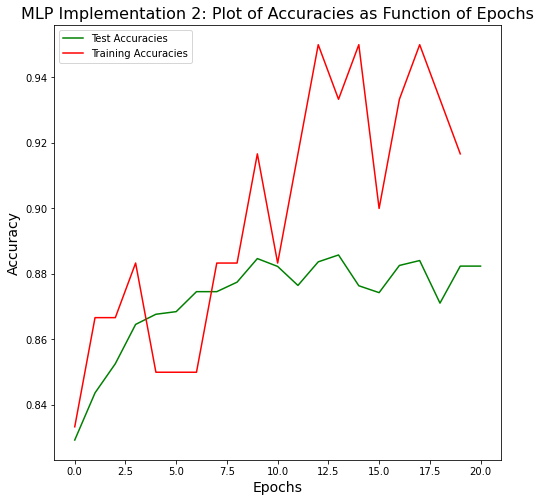

In [ ]:
# Instantiate the model
model = Model()
# Add layers
model.add(Layer_Dense(X_train_fashion_normalized.shape[1], 512))
model.add(Activation_ReLU())
model.add(Layer_Dense(512, 512))
model.add(Activation_ReLU())
model.add(Layer_Dense(512, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
loss=Loss_CategoricalCrossentropy(),
optimizer=Optimizer_Adam(learning_rate=0.001),
accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()
# Train the model
model.train(X_train_fashion_normalized, y_train_fashion, validation_data=(X_test_fashion_normalized, y_test_fashion),
epochs=20, batch_size=60, print_every=100)
model.evaluate(X_test_fashion_normalized, y_test_fashion)

plt.figure(figsize=(8, 8))
plt.title("MLP Implementation 2: Plot of Accuracies as Function of Epochs", fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(model.validation_accuracies, 'g-',label='Test Accuracies')
plt.plot(model.training_accuracies, 'r-',label='Training Accuracies')
plt.legend()